In [3]:
import pandas as pd
df = pd.read_csv("mbti_1.csv")

In [4]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


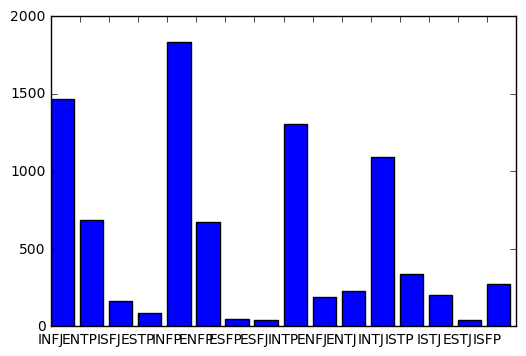

In [5]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(16)
types = set(df['type'])
values = [int(len(df[df['type'] == type_])) for type_ in types]
plt.bar(x,values)
plt.xticks(x,list(types))
plt.show()

In [6]:
len(df[df['type'] == 'INTJ'])

1091

In [7]:
from sklearn.model_selection import train_test_split
def load_data(train_data,limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #random.shuffle(train_data)
    train_data = train_data[-limit:]
    Y,X = train_data["type"], train_data["posts"]
    y = []
    for y_ in Y:
        if y_[0] == 'I' : INTROVERTED = True
        else: INTROVERTED = False
        if y_[1] == 'N' : INTUTIVE=  True
        else: INTUTIVE=  False
        if y_[2] == 'T' : THINKING=  True
        else: THINKING= False
        if y_[3] == 'T' : JUGEMENTAL=  True
        else: JUDGEMENTAL=  False
        y.append({'INTROVERTED':INTROVERTED,"INTUTIVE":INTUTIVE,"THINKING":THINKING,"JUDGEMENTAL":JUDGEMENTAL})
            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    return (X_train, y_train), (X_test, y_test)

In [8]:
load_data(df)

((5047    '[quote=agokcen;534073] So am I, but does that...
  1640    'estj to the max|||What is Caitlyn?|||Hmmm I'd...
  1290    'Nope.  Not now, not ever.  I'm too busy with ...
  3681    justaddallofthem|||I'm really glad you enjoyed...
  1380    'So....They always say the first ones always t...
  1933    'So I recently started working at a grocery st...
  4675    'I'm a soon to be Industrial Designer. From my...
  7656    'Far East for me|||Trying to beat Bugatti Veyr...
  3160    'Buy someone else's failure for peanuts, make ...
  2030    'Hugs!!!|||Welcome! I am an ENFP 7w8. sx/so.||...
  892     'Smoked about 15 cigarettes per day for six ye...
  4876    'I apparently look a bit intimidating and defe...
  4069    'How can you live with yourself? :tongue:|||An...
  4255    I'm an ENTP and my mom is most certainly and I...
  2       'Good one  _____   https://www.youtube.com/wat...
  7542    'intj =same functions in similar order.  we ar...
  2109    'Tbh all depends on maturity. 

In [13]:
from __future__ import unicode_literals, print_function
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding

from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv("mbti_1.csv")

def main(model=None, output_dir=None, n_iter=20, n_texts=2000):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('INTROVERTED')
    textcat.add_label('INTUTIVE')
    textcat.add_label('JUDGEMENTAL')
    textcat.add_label('THINKING')

    # load the IMBD dataset
    print("Loading MBTI data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(df,limit=n_texts)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
                  .format(losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    # test the trained model
    test_text = "This movie sucked"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)

def load_data(train_data,limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    #random.shuffle(train_data)
    train_data = train_data[-limit:]
    Y,X = train_data["type"], train_data["posts"]
    y = []
    for y_ in Y:
        if y_[0] == 'I' : INTROVERTED = True
        else: INTROVERTED = False
        if y_[1] == 'N' : INTUTIVE=  True
        else: INTUTIVE=  False
        if y_[2] == 'T' : THINKING=  True
        else: THINKING= False
        if y_[3] == 'T' : JUGEMENTAL=  True
        else: JUDGEMENTAL=  False
        y.append({'INTROVERTED':INTROVERTED,"INTUTIVE":INTUTIVE,"THINKING":THINKING,"JUDGEMENTAL":JUDGEMENTAL})
            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    return (X_train, y_train), (X_test, y_test)

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

main(output_dir="./model")

Created blank 'en' model
Loading MBTI data...
Using 2000 examples (400 training, 1600 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
76.717	0.811	0.854	0.832
49.800	0.801	0.937	0.864
27.494	0.814	0.925	0.866
16.789	0.817	0.922	0.866
10.516	0.821	0.919	0.867
7.112	0.823	0.920	0.869
5.760	0.832	0.902	0.866
4.125	0.827	0.915	0.869
9.899	0.819	0.924	0.868
3.590	0.812	0.934	0.869
2.607	0.812	0.938	0.870
3.661	0.815	0.935	0.871
1.442	0.824	0.922	0.870
1.369	0.828	0.912	0.868
1.249	0.828	0.914	0.869
1.002	0.826	0.917	0.869
1.239	0.824	0.918	0.868
0.922	0.825	0.916	0.868
0.754	0.827	0.916	0.869
0.754	0.826	0.916	0.869
This movie sucked {'INTROVERTED': 0.7885227799415588, 'INTUTIVE': 0.024210458621382713, 'JUDGEMENTAL': 0.18807746469974518, 'THINKING': 0.7338338494300842}
Saved model to model
Loading from model
This movie sucked {'INTROVERTED': 0.7885227799415588, 'INTUTIVE': 0.024210458621382713, 'JUDGEMENTAL': 0.18807746469974518, 'THINKING': 0.7338338494300842}
